# Expanded Association Study for rs699585
Additional cord blood samples were genotyped to perform an association study. A significant portion for the contents of this notebook, particularly those of sections 1 and 2, is identical to what was shown in the file 'association_study_800.ipynb'.

In [1]:
#Import and start Hail
import hail as hl
hl.stop() #Stop if it was already running.

In [2]:
import pandas as pd
import numpy as np
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://ip164-74.pool1.hus-b.bmc.lu.se:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.60-de1845e1c2f6
LOGGING: writing to /home/antton/TFM/scripts/SNP_association_notebooks/hail-20210607-1607-0.2.60-de1845e1c2f6.log


# 1 - Phenotype Data

Here we load and clean up output obtained from AliGater. We select only those phenotypes we are interested on and produce a clean DataFrame with log normalized data to be used in the association study.

## 1.1 - Data extraction and cleanup

In [3]:
#Take the data in the gating output file and put it in a DataFrame

#phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_2021-03-23.txt'
#phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_feb16.txt' #OG file. Signal here?

phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_2021-05-09.txt'
pheno_df = pd.read_table(phenos_filepath, na_values='None')

In [4]:
# Remove samples that have been gated incorrectly

#with open('/home/antton/TFM/samples_to_remove_mar24.txt', 'r') as f: #OG file 

with open('/home/antton/TFM/samples_to_remove_combined_maj1117.txt', 'r') as f:
#Text file contaning names of samples to remove

    samples_to_remove = []
    for line in f:
        samples_to_remove.append('fcs/'+line.rstrip().replace('-','/'))
pheno_df = pheno_df[~pheno_df.sampleName.isin(samples_to_remove)]
print('Removed '+str(len(samples_to_remove))+' incorrectly gated samples')
pheno_df


Removed 239 incorrectly gated samples


,sampleName,PBMC,PBMC/total,CD34+,CD34+/CD45+,CD3+,CD3+/CD45+,CD4+_1,CD4+_1/CD3+,CD8+,...,CMP_2/Lin-CD34+,MEP_1,MEP_1/CD34+,MEP_2,MEP_2/Lin-CD34+,GMP_1,GMP_1/CD34+,GMP_2,GMP_2/Lin-CD34+,Unnamed: 67
0,fcs/181029 CB 60min/A1 27,330981.0,0.730082,4820.0,0.019324,169542.0,0.679731,101781.0,0.600329,31086.0,...,0.410263,455.0,0.094398,455.0,0.113892,435.0,0.090249,435.0,0.108886,NaN
1,fcs/181029 CB 60min/A2 28,324988.0,0.623536,7762.0,0.034297,108781.0,0.480658,73911.0,0.679448,10312.0,...,0.367021,611.0,0.078717,611.0,0.095588,779.0,0.100361,779.0,0.121871,NaN
2,fcs/181029 CB 60min/A3 29,397389.0,0.677119,4293.0,0.013049,140557.0,0.427233,82923.0,0.589960,26871.0,...,0.338363,348.0,0.081062,348.0,0.097234,719.0,0.167482,719.0,0.200894,NaN
3,fcs/181029 CB 60min/A4 30,1190625.0,0.688036,3962.0,0.003569,441164.0,0.397383,298434.0,0.676470,72573.0,...,0.381533,345.0,0.087077,345.0,0.110612,571.0,0.144119,571.0,0.183071,NaN
4,fcs/181029 CB 60min/A5 31,542152.0,0.723091,14330.0,0.028827,229501.0,0.461670,160066.0,0.697452,50212.0,...,0.295338,1089.0,0.075994,1089.0,0.096150,2795.0,0.195045,2795.0,0.246777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,fcs/210226 CB/A2 2997,396810.0,0.613360,1378.0,0.004302,239068.0,0.746364,95541.0,0.399639,27395.0,...,0.390658,130.0,0.094340,130.0,0.138004,152.0,0.110305,152.0,0.161359,NaN
3076,fcs/210305 CB/A1 2981,1066088.0,0.610435,7440.0,0.008195,340028.0,0.374539,217738.0,0.640353,42321.0,...,0.438834,499.0,0.067070,499.0,0.081284,817.0,0.109812,817.0,0.133084,NaN
3077,fcs/210305 CB/A2 2997,336301.0,0.519761,1808.0,0.006491,198522.0,0.712685,82299.0,0.414559,27904.0,...,0.512857,102.0,0.056416,102.0,0.072857,165.0,0.091261,165.0,0.117857,NaN
3078,fcs/210305 CB_correct samples name/A2 2997,336301.0,0.519761,1808.0,0.006491,198522.0,0.712685,82299.0,0.414559,27904.0,...,0.512857,102.0,0.056416,102.0,0.072857,165.0,0.091261,165.0,0.117857,NaN


In [5]:
#List of phenotypes that we are interested on


selected_phenotype_list = ['CD34+/CD45+', #OG
                           'linneg_cd34pos/CD45+',
                           'HSC_1/CD34+',
                           'MPP_1/CD34+',
                           'B-NK_1/CD38+',
                           'B-NK_2/CD34+',
                           'CMP_1/CD34+',
                           'MEP_1/CD34+']

'''
#List of phenotypes used in the Mantri et al comparison
selected_phenotype_list = ['HSC_1/CD34+',
                           'MPP_1/CD34+',
                           'CMP_1/CD34+',
                           'GMP_1/CD34+',
                           'MEP_1/CD34+',
                           'B-NK_2/CD34+',
                           'CD10+(MLP)_2/CD34+']
'''

"\n#List of phenotypes used in the Mantri et al comparison\nselected_phenotype_list = ['HSC_1/CD34+',\n                           'MPP_1/CD34+',\n                           'CMP_1/CD34+',\n                           'GMP_1/CD34+',\n                           'MEP_1/CD34+',\n                           'B-NK_2/CD34+',\n                           'CD10+(MLP)_2/CD34+']\n"

In [6]:
def drop_none_na(input_df):
    # Function that replaces 'None's with 'NaN's and then drops all 'NaN's in a DataFrame.
    # Also changes contents to float
    input_df = input_df.dropna().copy()
    input_df = input_df.astype(float)
    
    return input_df

In [7]:

#Create and add a 'CBID' column to the DataFrame, then rename the indeces using that column.
CBID_col_middle_step = pheno_df['sampleName'].tolist()
CBID_col = ['CB'+x.split()[-1].split('-')[0] for x in CBID_col_middle_step]
pheno_df.insert(0,'CBID',CBID_col)

#Change axis
pheno_df.set_axis(pheno_df['CBID'].tolist(),axis='rows', inplace=True)

#Make sub-DataFrame containing only phenotypes of interest
selected_pheno_df = pheno_df[selected_phenotype_list].copy()

#Drop the NA values ONCE WE HAVE DECIDED THE RELEVANT PHENOTYPES
selected_pheno_df = drop_none_na(selected_pheno_df)

#Dealing with duplicates
#The current approach is to just drop the duplicates. The ideal approach would be to calculate the mean.
selected_pheno_df = selected_pheno_df[~selected_pheno_df.index.duplicated(keep='last')].copy()

selected_pheno_df

,CD34+/CD45+,linneg_cd34pos/CD45+,HSC_1/CD34+,MPP_1/CD34+,B-NK_1/CD38+,B-NK_2/CD34+,CMP_1/CD34+,MEP_1/CD34+
CB31,0.028827,0.022784,0.059595,0.134822,0.025039,0.013538,0.233426,0.075994
CB32,0.011012,0.008928,0.067944,0.147362,0.028084,0.015768,0.338810,0.100883
CB33,0.009550,0.008151,0.051780,0.100618,0.097561,0.058841,0.307443,0.085319
CB35,0.012439,0.006486,0.022882,0.031646,0.025242,0.011441,0.231500,0.095910
CB37,0.023148,0.019312,0.070027,0.128992,0.055784,0.032505,0.263458,0.087933
...,...,...,...,...,...,...,...,...
CB2991,0.009278,0.007398,0.111979,0.089992,0.041378,0.023669,0.350955,0.062838
CB3018,0.012751,0.010329,0.116860,0.088640,0.011097,0.006512,0.369030,0.071274
CB2981,0.008195,0.006762,0.052285,0.121102,0.038112,0.023118,0.362097,0.067070
CB2997,0.006491,0.005026,0.084071,0.109513,0.020508,0.011615,0.397124,0.056416


## 1.2 - Normalization of the Phenotype Data + Additional Cleanup
Once we have the desired phenotype data and we have dropped the repeats and faulty samples, we normalize the data using log normalization. This is necessary for it to be usable for the regression.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import json

sns.set_style("whitegrid")

CD34+/CD45+


<AxesSubplot:>

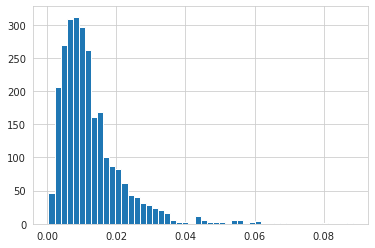

In [9]:
#Most Phenotype data is NOT normally distributed
sPheno_name = selected_pheno_df.columns.tolist()[0]
print(sPheno_name)
selected_pheno_df[sPheno_name].astype(float).hist(bins=50)

In [10]:
def log_normalize(input_df):
    #Log normalized and median centered!

    normalized_input_df = pd.DataFrame(columns = input_df.columns.tolist())
    normalized_input_df = np.log2(input_df) #- np.log2(input_df).median() #Median centered
    normalized_input_df = normalized_input_df.astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    return normalized_input_df

normal_pheno_df = log_normalize(selected_pheno_df)
normal_pheno_df

/home/antton/anaconda3/envs/python27env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """


,CD34+/CD45+,linneg_cd34pos/CD45+,HSC_1/CD34+,MPP_1/CD34+,B-NK_1/CD38+,B-NK_2/CD34+,CMP_1/CD34+,MEP_1/CD34+
CB31,-5.116455,-5.455855,-4.068659,-2.890872,-5.319695,-6.206838,-2.098960,-3.717963
CB32,-6.504741,-6.807502,-3.879520,-2.762560,-5.154102,-5.986840,-1.561454,-3.309240
CB33,-6.710254,-6.938814,-4.271463,-3.313042,-3.357552,-4.087038,-1.701607,-3.550986
CB35,-6.328992,-7.268469,-5.449632,-4.981853,-5.308049,-6.449632,-2.110919,-3.382169
CB37,-5.432946,-5.694336,-3.835937,-2.954649,-4.164007,-4.943214,-1.924355,-3.507445
...,...,...,...,...,...,...,...,...
CB2991,-6.751980,-7.078552,-3.158702,-3.474066,-4.594997,-5.400836,-1.510641,-3.992221
CB3018,-6.293264,-6.597167,-3.097152,-3.495904,-6.493633,-7.262617,-1.438188,-3.810490
CB2981,-6.931019,-7.208318,-4.257461,-3.045704,-4.713606,-5.434822,-1.465553,-3.898191
CB2997,-7.267424,-7.636392,-3.572251,-3.190822,-5.607683,-6.427862,-1.332339,-4.147754


## Quantile normalize!!!

def quantile_normalize(input_df):
    
    normalized_input_df = pd.DataFrame(columns = input_df.columns.tolist())
    rank_mean = input_df.stack().groupby(input_df.rank(method='first').stack().astype(int)).mean()
    normalized_input_df = input_df.rank(method='min').stack().astype(int).map(rank_mean).unstack()
    
    return normalized_input_df

normal_pheno_df = quantile_normalize(selected_pheno_df)
normal_pheno_df

Now that the data has been normalized, the same phenotype looks like this:

<AxesSubplot:>

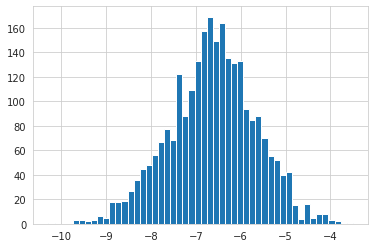

In [11]:
#sPheno_name = selected_pheno_df.columns.tolist()[6]

normal_pheno_df[sPheno_name].astype(float).hist(bins=50)

# 2 - QOL preparations
We will prepare some useful dictionaries and lists to make our life easier down the line.

First of all, we will need to lift over our position data from hg38 to hg37, since our genotype results are in hg37.

We will also create dictionaries to map position and SNP rsID, mapping it in both reference genomes.

Finally, we will create a DataFrame containing extra info for plotting, and we'll save it into a file.

In [12]:
#Load LiftOver infor in Hail to
#RUN ONLY ONCE
rg37 = hl.get_reference('GRCh37') 
rg38 = hl.get_reference('GRCh38')
#GRCh37 to GRCh38
rg37.add_liftover('/home/antton/TFM/hail-common/references/references_grch37_to_grch38.over.chain.gz', rg38)
rg38.add_liftover('/home/antton/TFM/hail-common/references/references_grch38_to_grch37.over.chain.gz', rg37)

In [13]:
#Excel file containing some info on the candiade SNPs such as hg38 location and most likely connected gene
path_to_SNPtable = '/home/antton/TFM/aitzkoa_SNP_association_data/snp_list.xlsx'

We'll build a DataFrame named 'SNPs_df' that will contain metadata on our 14 SNPs of interest:

In [14]:
#Load Excel with info about the SNPs of interest. (Note that it's in In GRCh38!)
SNPs_df = pd.read_excel(path_to_SNPtable, na_values=None)

#Clean up the DataFrame a bit.
SNPs_df.set_axis(SNPs_df.iloc[0].tolist(),axis='columns', inplace=True) #Set reasonable column names
SNPs_df = SNPs_df.iloc[1:].copy() # Drop first row, since it contains column names
SNPs_df.reset_index(inplace=True)
SNPs_df.drop('index', axis=1, inplace=True)
SNPs_df.drop(13, axis=0, inplace=True) #Drop variant with rsID since it's too rare to be in the genotype info anyway

We will clean up the hg38 loci information formatting, and add an additonal column with hg37 loci information.

In [15]:
#Clean up formatting in the 'Position (hg38)' column of 'SNPs_df'
cleaned_hg38_list = list()
hg37_list = list()
hg38_to_RSID_dict = dict()
hg37_to_RSID_dict = dict()
for index in SNPs_df.index.tolist(): #Loop through every row of the DF
    
    #Clean the formatting of the position information to standard Hail format (chr:locus)
    split_hg38 = SNPs_df.loc[index]['Position (hg38)'].split(':')
    chromosome =  split_hg38[0][3:] #Chr number string
    loc_within_chr_hg38 = split_hg38[1] #Position within the chromosome
    cleaned_hg38_str = chromosome+':'+loc_within_chr_hg38
    cleaned_hg38_list.append(cleaned_hg38_str)  # List that will be added to DF as column
    
    #Make reference dict with hg38 position as key and RSID as element
    hg38_to_RSID_dict[cleaned_hg38_str] = SNPs_df.iloc[index-1,SNPs_df.columns.get_loc('Marker')]
    
    #Lift over hg38 position to hg37, and produce a similar dict map
    hail_liftover = hl.eval(hl.liftover(hl.locus('chr'+chromosome, int(loc_within_chr_hg38), 'GRCh38'), 'GRCh37'))
    hg37_str = chromosome+':'+str(hail_liftover.position)
    hg37_list.append(hg37_str)  # List that will be added to DF as column
    hg37_to_RSID_dict[hg37_str] = SNPs_df.iloc[index,SNPs_df.columns.get_loc('Marker')]

SNPs_df['Position (hg38)'] = cleaned_hg38_list
SNPs_df.insert(1, 'Position (hg37)', hg37_list)

A few of the SNPs don't exist in our genotype data, but we can use variants in close LD with them instead to complete the same analysis. Appropiate proxy SNPs were manually checked for and added to a tsv file 'proxy_list.tsv'.

In [16]:
#Proxy information
#Empty lists that we will fill up shortly
n_SNPs = len(SNPs_df.index)
has_proxy_bool_list = [False]*n_SNPs
proxy_list = [None]*n_SNPs
proxy_hg37_list = [None]*n_SNPs
proxy_hg38_list = [None]*n_SNPs

#File contains manually selected proxies as well as their positions in hg38 and hg37(Using LiftOver)
proxy_file_path = '/home/antton/TFM/data/proxy_list.tsv'
with open(proxy_file_path, 'r') as proxy_file:
    for line in proxy_file:
        og_SNP, proxy_SNP, proxy_pos_38, proxy_pos_liftover = line.split()
        if og_SNP in SNPs_df['Marker'].tolist():
            if proxy_SNP == 'NaN':
                proxy_SNP = None
            
            index = SNPs_df[SNPs_df['Marker']==og_SNP].index.to_list()[0]
            has_proxy_bool_list[index] = True
            proxy_list[index] = proxy_SNP
            proxy_hg37_list[index] = proxy_pos_liftover[3:]
            proxy_hg38_list[index] = proxy_pos_38[3:]

#Add columns to store the proxies for the SNPs not in the inputation
#(proxies manually selected from ENSMBL and put in a file)
SNPs_df.insert(3,'Proxy', proxy_list) 
SNPs_df.insert(4,'Proxy Position (hg37)', proxy_hg37_list) 
SNPs_df.insert(5,'Proxy Position (hg38)',proxy_hg38_list) 
SNPs_df.insert(6,'needs_proxy', has_proxy_bool_list)  

SNPs_df

,Marker,Position (hg37),Position (hg38),Proxy,Proxy Position (hg37),Proxy Position (hg38),needs_proxy,MAF (%),Info,Min/Maj1,...,P,b,P,b,P,Phet,I2,postProb,Pthrs,Candidate gene
0,rs2047094,1:8917815,1:8857756,None,None,None,False,49.215,0.995567,NaN,...,4.3e-11,-0.1407,2.1e-06,-0.10191,1.3e-15,0.15,52.4,0.2617,8.2e-09,"ENO1, RERE"
1,rs309137,2:136765951,2:136008381,None,None,None,False,25.53,0.980694,NaN,...,1.7e-15,-0.06777,0.011,-0.12104,1.3e-15,0.016,82.8,0.1834,1.4e-09,"CXCR4, (? MCM6, DARS)"
2,rs11688530,2:136883432,2:136125862,None,None,None,False,7.118,0.995239,NaN,...,1.2e-15,0.22836,1.1e-07,0.23227,7.9e-22,0.91,0,0.1953,1.4e-09,CXCR4
3,rs555647251,2:136894330,2:136136760,None,,,True,0.083,0.928836,NaN,...,3.3e-10,1.7942,0.01,1.73974,1.2e-11,0.93,0,0.242,1.4e-09,CXCR4
4,rs10193623,2:136901560,2:136143990,rs6726457,2:136900469,2:136142899,True,5.872,0.999618,NaN,...,1.4e-08,-0.23506,2.3e-08,-0.20036,2.8e-15,0.3,6.6,0.399,1.4e-09,CXCR4
5,rs201494641,3:37519413,3:37477922,rs17227404,3:37519563,3:37478072,True,12.952,0.997454,NaN,...,8.6e-08,-0.1575,7.8e-05,-0.12267,4.7e-11,0.32,0,0.0626,1.4e-09,ITGA9
6,rs7705526,5:1285974,5:1285859,None,None,None,False,33.978,0.983155,NaN,...,3.4e-09,0.05105,0.091,0.08114,1.5e-09,0.27,19.1,NaN,1.4e-09,TERT
7,rs1029094211,5:159433799,5:160006792,None,,,True,0.487,0.954976,NaN,...,1.7e-07,-0.06151,0.88,-0.67727,7.2e-07,0.096,63.9,NaN,8.2e-09,TTC1
8,rs1991866,8:130624105,8:129611859,None,None,None,False,44.858,0.992796,NaN,...,5.9e-08,-0.06728,0.018,-0.07518,3.5e-09,0.76,0,NaN,1.4e-09,CCDC26
9,rs699585,12:63306132,12:62912352,None,None,None,False,46.07,0.999503,NaN,...,1.2e-17,-0.1508,2e-07,-0.12633,2.2e-23,0.35,0,0.0619,1.4e-09,PPM1H


In [17]:
#Reverse dictionary to get the mapping to work the other way around too.
RSID_to_hg37_dict = {v: k for k, v in hg37_to_RSID_dict.items()}

## 2.2 - SNP selection

In [18]:
#This time around, we are only interested on the SNP in PPM1H
desired_SNP_list = ['rs699585'] 

# 3 - Genotype Data
Genotype data for the specific candidate SNPs is loaded from a .txt file into a DataFrame. Preliminary checking is done in this file, but the final plotting is done in Matlab, which requires the data to be exported to a file.

## 3.1 - Data Extraction

### 3.1.1 - First half: old genotype data

In [19]:
from os import listdir
from os.path import isfile, join
import glob

#Path to sample file
sample_path = '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/Sweden_CordBlood_wAliases_201130_ID2first.sample'
#Main folder with all .BGEN files. 
path_to_bgens = '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/'
#List of individual file paths
bgen_paths_list = [f for f in glob.glob(path_to_bgens+'*.bgen') if isfile(join(path_to_bgens, f))]


In [20]:
#Create index files for each BGEN file. Only needs to be run if files don't already exist!
#hl.index_bgen(bgen_paths_list) 

In [21]:
#Generate Matrix Table from BGENs + sample file
mt = hl.import_bgen(bgen_paths_list, entry_fields=['GT','GP'], sample_file=sample_path)

2021-06-07 16:07:57 Hail: INFO: Number of BGEN files parsed: 22
2021-06-07 16:07:57 Hail: INFO: Number of samples in BGEN files: 760
2021-06-07 16:07:57 Hail: INFO: Number of variants across all BGEN files: 21580275


Out of the complete genotype data (over 21 million variants) we will take info of the ones that we are interested on!

In [22]:
#Create sub-Matrix Table "mt_hits" by filtering the mt to keep the loci of interest only

final_loci_list = SNPs_df[SNPs_df['Marker'] == desired_SNP_list[0]]['Position (hg37)'].tolist()

#final_loci_list is the CORRECT list of all REAL positions being considered, 2 of them being proxys

#Make the list of loci of interest into Hail format locus info list (in hg37)
final_loci_hail = [hl.parse_locus(x, reference_genome='GRCh37') for x in final_loci_list]
final_SNP_list = [hg37_to_RSID_dict[x] for x in final_loci_list]
mt_hits = mt.filter_rows(hl.literal(final_loci_hail).contains(mt.locus))

print('Adding the Proxys, the number of SNPs is: ', len(final_loci_list))

Adding the Proxys, the number of SNPs is:  1


In [23]:
SNP_table_name = "14SNP_genotype_table_jun3.txt"

In [24]:
#Save 'mt_hits' to file. Not necessary if file alread exists!
#mt_hits.GT.n_alt_alleles().export("/home/antton/TFM/data/"+SNP_table_name) 


In [25]:
genotype_filepath = "/home/antton/TFM/data/"+SNP_table_name

# Get DF with allelelic information of all candidate SNPs for each sample
allele_df = pd.read_table(genotype_filepath)
allele_df.set_axis(allele_df['locus'].tolist(),axis='rows', inplace=True) 

# Keep only specified subset of SNPs, and rotate DF so that the axis equals sample name
#loci_present_in_both = list(set(allele_df.index.tolist()).intersection(SNPs_df['Position (hg37)'].values))
#positions_of_interest_list = sorted(loci_present_in_both, key=lambda x: int(x.split(':')[0]))
#Note that 'rs699585:T:G' is in strong LD with 'rs772559:A:G'

rotated_alleles_df = allele_df.drop(['locus','alleles'],axis=1).T.astype(float).copy()
genotype_firstHalf_df = pd.DataFrame(rotated_alleles_df[final_loci_list].copy()) #Series to dataframe



#Rename columns from position to RSID
genotype_firstHalf_df = genotype_firstHalf_df.rename(columns= hg37_to_RSID_dict).copy()
genotype_firstHalf_df

,rs699585
CB1,2.0
CB2,0.0
CB3,1.0
CB4,0.0
CB5,0.0
...,...
CB544,2.0
CB650,1.0
CB700,2.0
CB750,2.0


### 3.1.2 Second half: newly genotpyed data
Here we'll load the additional genotype data. Note that it is for SNP 'rs772559'. While not the same SNP, it is in very strong LD (0.99) with 'rs699585'. It's genotype is AG instead of TG.

In [26]:
genotype_secondHalf_filepath = '/home/antton/TFM/data/Plates 12-20_CSVcopy.csv'
genotype_secondHalf_df = pd.read_csv(genotype_secondHalf_filepath)

#Samples that failed in genotyping are marked as '0 0'. We drop them here.
genotype_secondHalf_df = genotype_secondHalf_df[genotype_secondHalf_df.rs772559 != '0 0'].copy()

#Index DF by sample name. Drop 'SampleName' column.
genotype_secondHalf_df['SampleName'] = genotype_secondHalf_df['SampleName'].str.upper()
genotype_secondHalf_df.set_axis(genotype_secondHalf_df['SampleName'].tolist(),axis='rows', inplace=True)
genotype_secondHalf_df = genotype_secondHalf_df.drop('SampleName', axis=1)

#Replace alleles by floats, where 0.0 is minor-mino, 1.0 is major-minor, and 2.0 is major-major.
allele_2_num_dict = {' G G':2.0, ' A A':0.0, ' A G':1.0}
genotype_secondHalf_df = genotype_secondHalf_df.replace({"rs772559": allele_2_num_dict})

#Finally, rename the column to 'rs699585'. Even if not strictly true, high LD allows us to do this.
genotype_secondHalf_df['rs699585'] = genotype_secondHalf_df['rs772559']
genotype_secondHalf_df.drop('rs772559', axis=1, inplace=True)

genotype_secondHalf_df

,rs699585
CB858,2.0
CB859,0.0
CB861,2.0
CB862,1.0
CB863,0.0
...,...
CB2016,0.0
CB2017,2.0
CB2018,0.0
CB2019,2.0


In [27]:
genotype_df = pd.concat([genotype_firstHalf_df,genotype_secondHalf_df]).astype(float)
genotype_df

,rs699585
CB1,2.0
CB2,0.0
CB3,1.0
CB4,0.0
CB5,0.0
...,...
CB2016,0.0
CB2017,2.0
CB2018,0.0
CB2019,2.0


## 3.2 - Create metadata additional info DF

In [28]:
#Create DF with additonal information necessary for the plotting, such as alleleic content and most likely gene
extra_df = pd.DataFrame()

for index, rsID in enumerate(final_SNP_list):
    
    index_bool_vector = SNPs_df['Marker'] == rsID
    gene_name = SNPs_df[index_bool_vector]['Candidate gene'].values[0]
    has_proxy = SNPs_df[index_bool_vector]['needs_proxy'].values[0]
    if has_proxy:  #hg37 position used in hail (so proxy if there is one), used as a key for alleleDF
        hg37_loc_key = SNPs_df[index_bool_vector]['Proxy Position (hg37)'].values[0] 
    else:
        hg37_loc_key = SNPs_df[index_bool_vector]['Position (hg37)'].values[0]
        
    #IMPORTANT: Note that the alleles marked here correspond to the proxy SNPs if a proxy was used!!
    alleles = allele_df.loc[hg37_loc_key]['alleles']

    extra_df[rsID] = [alleles, gene_name, has_proxy]


extra_df

,rs699585
0,"[""T"",""G""]"
1,PPM1H
2,False


# 4 - Analysis
Here we join Phenotype and Genotype data in a single DF, indexed by sample name, and use it to fit and plot our regression lines. We hope to see an effect in at least one of the phenotypes for some of the SNPs!

In [29]:
final_df = pd.concat([normal_pheno_df,genotype_df], axis=1, join_axes=[normal_pheno_df.index])

/home/antton/anaconda3/envs/python27env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [30]:
final_df = final_df.astype(float).replace([np.inf, -np.inf], np.nan).dropna().copy() #Discard 12 nan values?
final_df

,CD34+/CD45+,linneg_cd34pos/CD45+,HSC_1/CD34+,MPP_1/CD34+,B-NK_1/CD38+,B-NK_2/CD34+,CMP_1/CD34+,MEP_1/CD34+,rs699585
CB31,-5.116455,-5.455855,-4.068659,-2.890872,-5.319695,-6.206838,-2.098960,-3.717963,1.0
CB32,-6.504741,-6.807502,-3.879520,-2.762560,-5.154102,-5.986840,-1.561454,-3.309240,1.0
CB33,-6.710254,-6.938814,-4.271463,-3.313042,-3.357552,-4.087038,-1.701607,-3.550986,0.0
CB35,-6.328992,-7.268469,-5.449632,-4.981853,-5.308049,-6.449632,-2.110919,-3.382169,1.0
CB37,-5.432946,-5.694336,-3.835937,-2.954649,-4.164007,-4.943214,-1.924355,-3.507445,0.0
...,...,...,...,...,...,...,...,...,...
CB1967,-5.604350,-5.769766,-4.360324,-2.568910,-3.889628,-4.556143,-1.542504,-3.541914,0.0
CB1971,-6.723036,-6.986187,-4.458145,-2.597064,-5.047399,-5.821818,-1.884802,-3.478867,2.0
CB1893,-6.899063,-7.157819,-4.530186,-2.597551,-4.160521,-4.917411,-1.682042,-3.574292,2.0
CB1952,-8.237988,-8.654485,-4.501366,-3.138184,-4.357552,-5.268003,-1.646046,-3.817113,1.0


#TEST
#outlier removal

minVal_index = final_df['CMP_1/CD34+'].idxmin()
print(minVal_index)

final_df.drop(minVal_index, inplace=True)

In [32]:
#Drop outliers for CMP
#These two samples have very low CMP values. I get rid of them so that the final CMP plot is more clear.
#This barely has an effect on the p-value

final_df.drop('CB591', inplace=True)
final_df.drop('CB1715', inplace=True)

#List of phenotypes that we are interested on

selected_phenotype_list = [
                           'HSC/CD34+',
                           'MPP/CD34+',
                           'BNK/CD34+',
                           'CMP/CD34+',
                           'MEP/CD34+']

final_df = pd.read_csv('/home/antton/Matlab_scripts/CB_PPM1H_data_DF.csv')
final_df = final_df.rename(columns={"12:63306132": "rs772559"}).copy()
print(final_df.columns.tolist())
final_df = final_df[selected_phenotype_list+["rs772559"]]
final_df

In [33]:
#Check allele distribution for selected SNP
MM = 0
Mm = 0
mm = 0

RSID = 'rs699585'

for sample in final_df.index.tolist():
    if final_df[RSID][sample] == 0.0:
        MM += 1
    elif final_df[RSID][sample] == 1.0:
        Mm += 1
    else:
        mm += 1
print('MM :', MM, ' Mm: ', Mm, ' mm: ', mm)
print('total: ', MM+Mm+mm)

MM : 591  Mm:  766  mm:  306
total:  1663


# Plotting

In [34]:
def plot_assoc(pheno_name, variant_name, p_value, pval_color):
    #Function that will plot boxplots of the desired SNP-phenotype combinations
    plt.figure()
    
    index_bool_vactor = SNPs_df['Marker'] == variant_name
    gene_name = SNPs_df[index_bool_vactor]['Candidate gene'].values[0]
    
    allele_list = ['M', 'm']
    comb_list = [allele_list[0]*2,allele_list[0]+allele_list[1],allele_list[1]*2]

    ax = sns.boxplot(x=final_df[variant_name],y=final_df[pheno_name])
    ax = sns.regplot(x=final_df[variant_name], y=final_df[pheno_name],
                             scatter=False,color='r',fit_reg=True, truncate=False)
    ax.set_xlabel(' p='+str(p_value), size='small', color=pval_color, weight='semibold')
    ax.set_title(variant_name+' '+gene_name+' '+pheno_name)
    ax.set_xticklabels(comb_list)
    

rs699585 CMP_1/CD34+


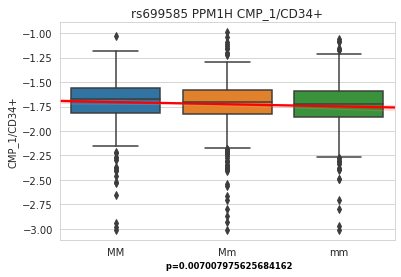

In [35]:
#For the desired SNP and phenotype lists, iterate through both and calculate the Ordinary Least Squares for each combination.
#Plot those with a p-value below the threshold.

pheno_list = normal_pheno_df.columns.tolist()
n_phenos = len(pheno_list)

p_threshold_soft = 0.05
p_threshold_hard = 0.05/n_phenos  #Bonferroni corrected threshold

pval_df = pd.DataFrame(index=final_SNP_list, columns = pheno_list) #Empty DF to be filled with p-values
for SNP in final_SNP_list:
    for phenotype in pheno_list:
        Y = final_df[phenotype]
        X = final_df[SNP]
        X = sm.add_constant(X.to_numpy())
        model = sm.regression.linear_model.OLS(Y,X)
        results = model.fit()
        p_value = results.pvalues['x1']
        pval_df[phenotype][SNP] = p_value

        if float(p_value) < p_threshold_hard:
            bonf_signifucant = True
            pval_color = 'red'
        else:
            bonf_signifucant = False
            pval_color = 'black'
            
        if float(p_value) < p_threshold_soft:
            print(SNP, phenotype)
            plot_assoc(phenotype, SNP, p_value, pval_color)


In [36]:
#Similar to 'extra_df', DataFrame that contains P-value info about the regression
pvalue_for_table_df = pval_df.loc[final_SNP_list]
pvalue_for_table_df


,CD34+/CD45+,linneg_cd34pos/CD45+,HSC_1/CD34+,MPP_1/CD34+,B-NK_1/CD38+,B-NK_2/CD34+,CMP_1/CD34+,MEP_1/CD34+
rs699585,0.965681,0.727021,0.0512723,0.685865,0.0941556,0.191253,0.00700798,0.734237


In [37]:
pvalue_for_table_df.to_csv(path_or_buf='/home/antton/Matlab_scripts/CB_2000pvalues_DF_jun4.csv')

In [38]:
final_df.to_csv(path_or_buf='/home/antton/Matlab_scripts/CB_data_DF_2000jun4.csv')

In [39]:
extra_df.to_csv(path_or_buf='/home/antton/Matlab_scripts/CB_extra_DF_2000jun4.csv')